In [1]:
%matplotlib inline
import os
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.image import imread
import torch
from torchvision import transforms
from analyze import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
from bounding_box import draw_bbox

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset, loader, model = load_model(device)
num_classes = len(dataset.classes)

In [3]:
transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def predict_fn(images):
    # convert back from (10, 224, 224, 3) to (10, 3, 224, 224)
    batch = []
    for image in images:
        tensor = torch.tensor([np.squeeze(subarray) for subarray in np.dsplit(image, 3)])
        tensor = transform(tensor)
        batch.append(tensor)
    batch = torch.stack(batch)
    return model(batch.to(device)).cpu().numpy()

In [4]:
def load_image(path):
    # load returns a tensor containing three 2D matrices, each containing a single pixel value for a channel
    image = Image.open(path)
    tensor = transforms.ToTensor()(image)
    # stack merges it into one 2D matrix containing a vector with 3 values, one for each channel
    # (3, 224, 224) => (224, 224, 3)
    tensor = np.stack([tensor[0], tensor[1], tensor[2]], axis=2)
    return tensor, image

In [5]:
with open('best10_bbox.json') as f:
    json_data = json.load(f)
data = {}
for label, images in json_data.items():
    if len(images) > 0:
        data[label] = images

In [7]:
def explain(tensor, image, image_name):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(tensor, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    draw_bbox(image_name, image)
    plt.imshow(image)
    plt.title(dataset.classes[label])

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    plt.show()

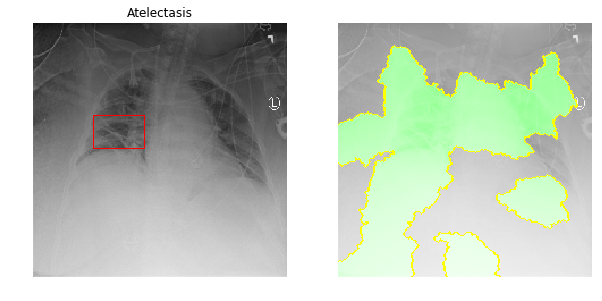

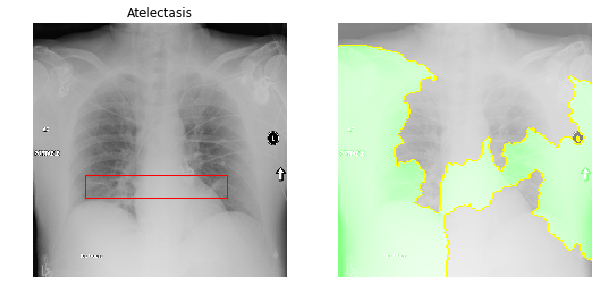

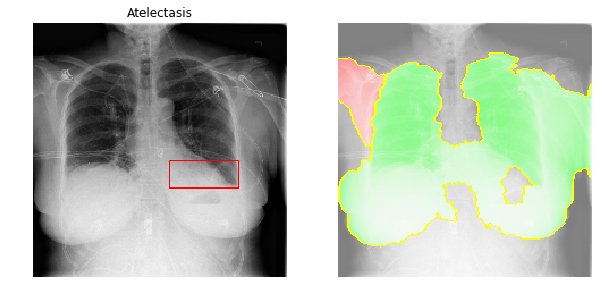

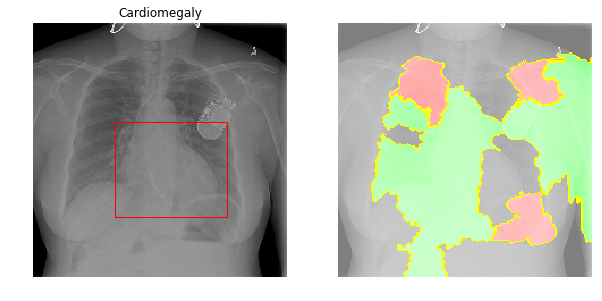

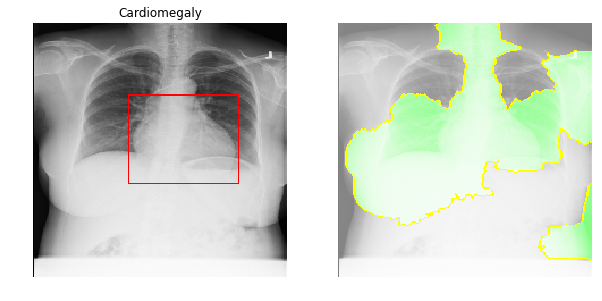

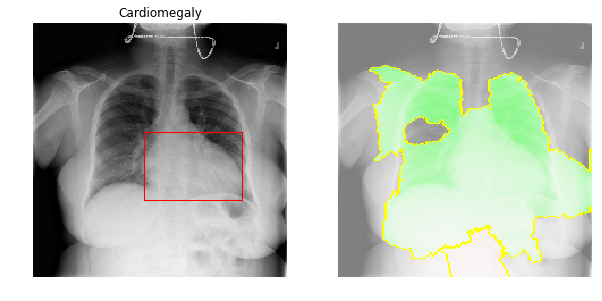

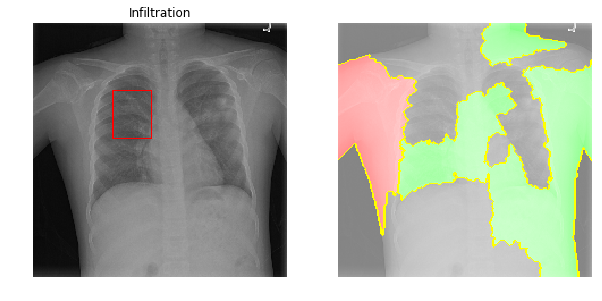

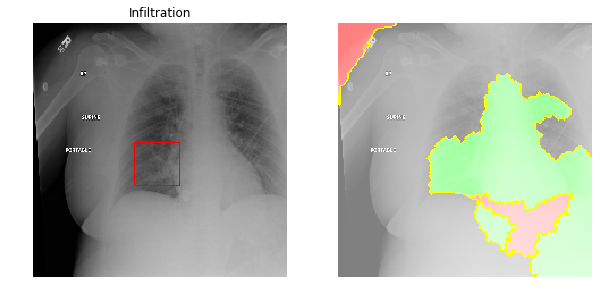

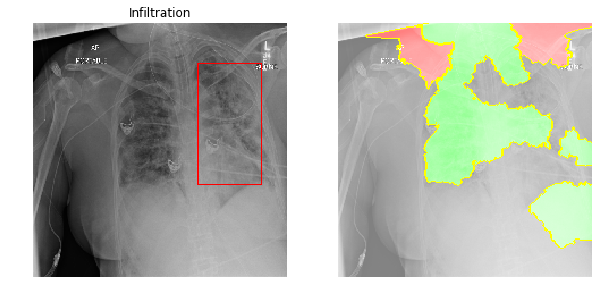

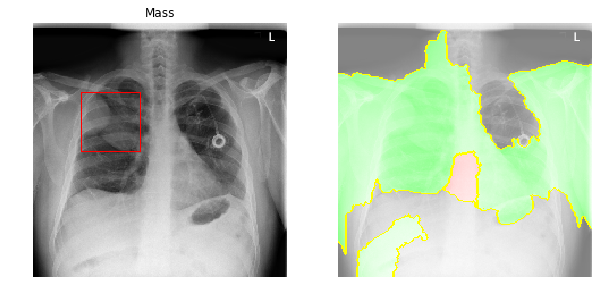

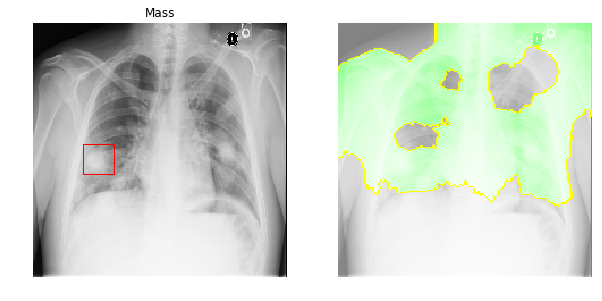

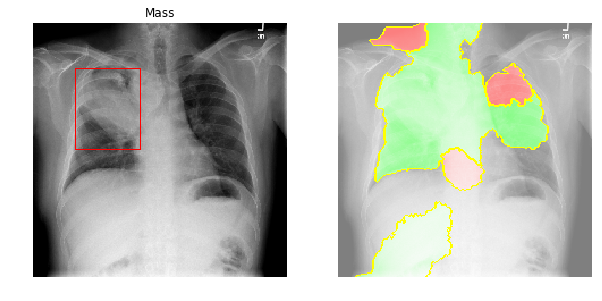

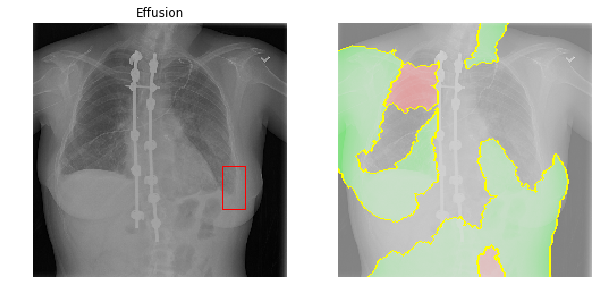

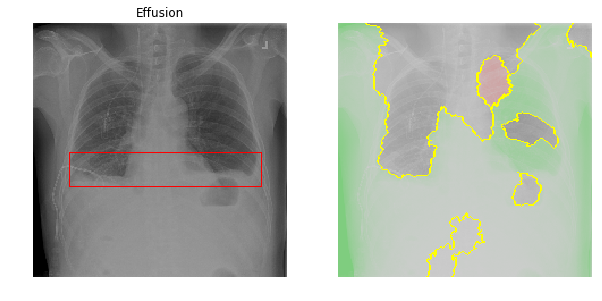

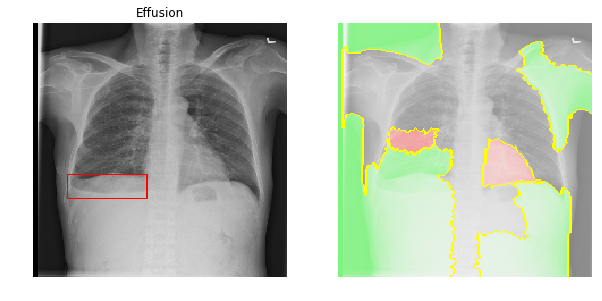

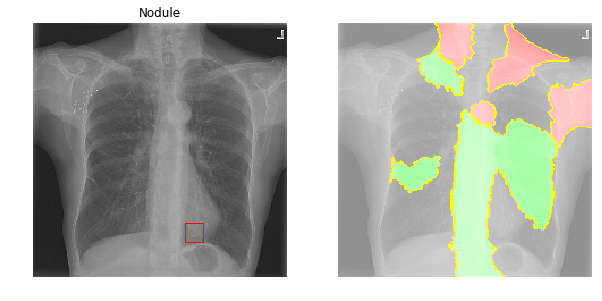

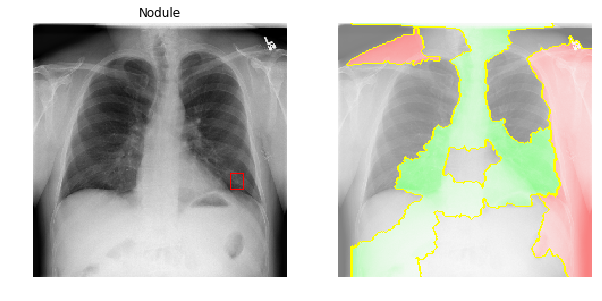

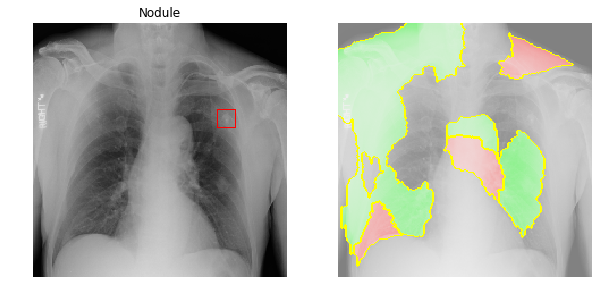

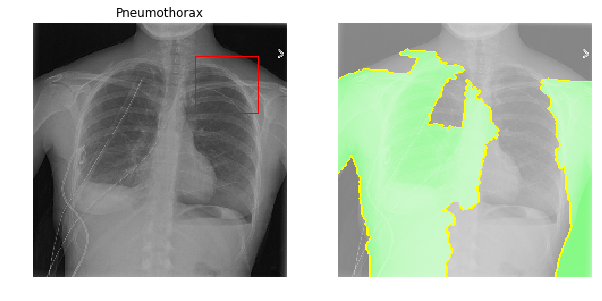

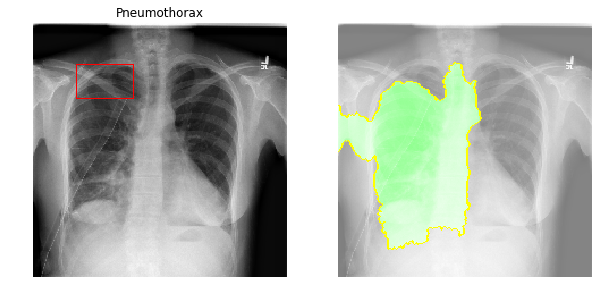

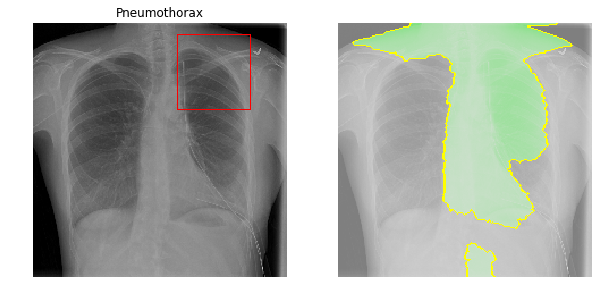

In [8]:
with torch.set_grad_enabled(False):
    for images in data.values():
        for image in images[:3]:
            tensor, img = load_image(os.path.join('..', 'data', 'processed_images', image['image']))
            explain(tensor, img, image['image'])